In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

2025-05-24 15:58:51.249672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748102331.541017      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748102331.627033      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Constants
BASE_PATH = '/kaggle/input/annam-ai/soil_classification-2025'
TRAIN_PATH = f'{BASE_PATH}/train'
TEST_PATH = f'{BASE_PATH}/test'
TRAIN_LABELS = f'{BASE_PATH}/train_labels.csv'
TEST_IDS = f'{BASE_PATH}/test_ids.csv'
IMG_SIZE = (64, 64)
COLOR_IGNORE = [(0, 0, 0), (255, 255, 255)]
COLOR_MARGIN = 15  # Add tolerance to dynamic thresholds

In [3]:
# Step 1: Load and preprocess labels
train_labels = pd.read_csv(TRAIN_LABELS)
label_map = {label: idx for idx, label in enumerate(train_labels['soil_type'].unique())}
inv_label_map = {v: k for k, v in label_map.items()}

In [4]:
# Step 2: Color-based feature extraction
def get_most_frequent_color(image):
    image = cv2.resize(image, IMG_SIZE)
    pixels = image.reshape(-1, 3)
    pixels = [tuple(p) for p in pixels if tuple(p) not in COLOR_IGNORE]
    most_common = Counter(pixels).most_common(1)
    return most_common[0][0] if most_common else (0, 0, 0)

def extract_color_features(folder):
    features = []
    ids = []
    for fname in os.listdir(folder):
        if fname.endswith('.jpg') or fname.endswith('.png'):
            img_path = os.path.join(folder, fname)
            image = cv2.imread(img_path)
            if image is None:
                continue
            color = get_most_frequent_color(image)
            features.append(color)
            ids.append(fname)
    return np.array(features), ids

In [5]:
train_features, train_ids = extract_color_features(TRAIN_PATH)
train_labels_ordered = [label_map[train_labels[train_labels['image_id'] == img]['soil_type'].values[0]] for img in train_ids]
train_labels_ordered = np.array(train_labels_ordered)

# Step 3: Determine dynamic color ranges
color_ranges = {}
for label in np.unique(train_labels_ordered):
    colors = train_features[train_labels_ordered == label]
    min_color = np.clip(np.min(colors, axis=0) - COLOR_MARGIN, 0, 255)
    max_color = np.clip(np.max(colors, axis=0) + COLOR_MARGIN, 0, 255)
    color_ranges[label] = (min_color, max_color)

In [6]:
# Step 4: Define CNN model
def load_images_for_cnn(folder, image_ids):
    X = []
    for fname in image_ids:
        img_path = os.path.join(folder, fname)
        image = load_img(img_path, target_size=IMG_SIZE)
        X.append(img_to_array(image) / 255.0)
    return np.array(X)

X_cnn = load_images_for_cnn(TRAIN_PATH, train_ids)
y_cnn = to_categorical(train_labels_ordered)
X_train, X_val, y_train, y_val = train_test_split(X_cnn, y_cnn, test_size=0.2)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-24 16:00:00.774096: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.5028 - loss: 1.1705 - val_accuracy: 0.7689 - val_loss: 0.6418
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7645 - loss: 0.6275 - val_accuracy: 0.8178 - val_loss: 0.4871
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8600 - loss: 0.3756 - val_accuracy: 0.8267 - val_loss: 0.4208
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8745 - loss: 0.3027 - val_accuracy: 0.8711 - val_loss: 0.3816
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8930 - loss: 0.2973 - val_accuracy: 0.8578 - val_loss: 0.3865
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9047 - loss: 0.2555 - val_accuracy: 0.8311 - val_loss: 0.4721
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9009 - loss: 0.2597 - val_accuracy: 0.9067 - val_loss: 0.2773
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9686 - loss: 0.1395 - val_accuracy: 0.9244 -

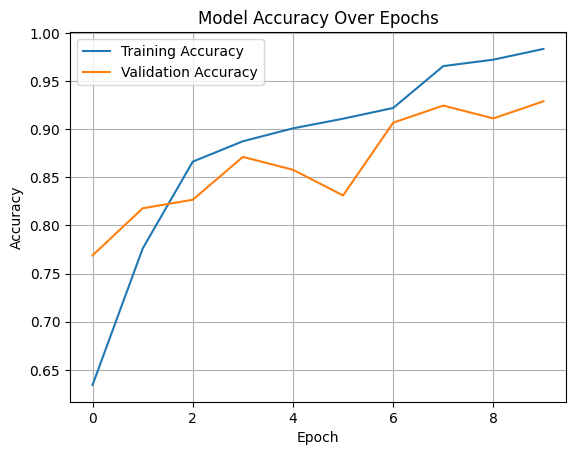

In [7]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.grid(True)
plt.show()

In [8]:
# Step 5: Predict on test set (just for an estimate)
test_ids_df = pd.read_csv(TEST_IDS)
test_features, test_ids = extract_color_features(TEST_PATH)
X_test_cnn = load_images_for_cnn(TEST_PATH, test_ids)

predictions = []
confidences = []
for i, color in enumerate(test_features):
    possible_labels = []
    for label, (min_col, max_col) in color_ranges.items():
        if np.all(color >= min_col) and np.all(color <= max_col):
            possible_labels.append(label)

    if len(possible_labels) == 1:
        pred_label = possible_labels[0]
        confidence = 1.0
    else:
        probs = model.predict(np.expand_dims(X_test_cnn[i], axis=0))[0]
        pred_label = np.argmax(probs)
        confidence = float(np.max(probs))

    predictions.append(inv_label_map[pred_label])
    confidences.append(confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
F1 Score (macro): 0.9842

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       1.00      0.97      0.98       384
    Clay soil       0.93      1.00      0.97       153
     Red soil       1.00      0.99      1.00       187
   Black Soil       0.98      1.00      0.99       173

     accuracy                           0.98       897
    macro avg       0.98      0.99      0.98       897
 weighted avg       0.99      0.98      0.98       897



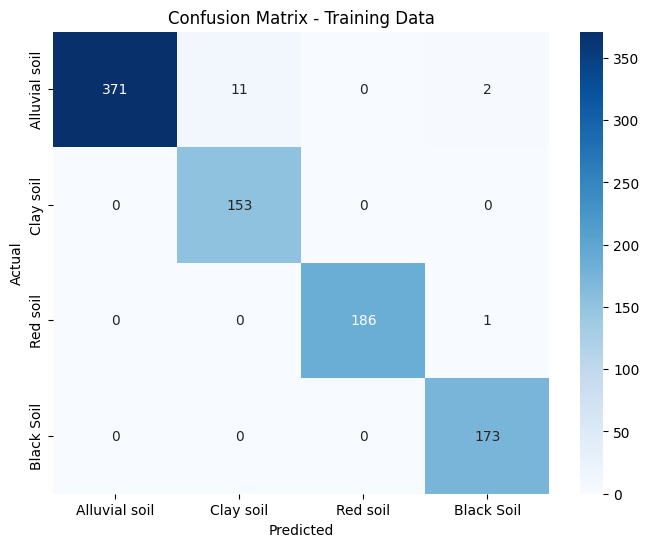

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on training set
y_train_true = np.argmax(y_train, axis=1)
y_train_pred = np.argmax(model.predict(X_train), axis=1)

# F1 Score (macro avg)
f1 = f1_score(y_train_true, y_train_pred, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_train_true, y_train_pred, target_names=[inv_label_map[i] for i in range(len(inv_label_map))]))

# Confusion matrix
cm = confusion_matrix(y_train_true, y_train_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=inv_label_map.values(), yticklabels=inv_label_map.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data')
plt.show()

In [10]:
# Step 6: Save predictions
submission = pd.DataFrame({'image_id': test_ids, 'soil_type': predictions, 'confidence': confidences})
submission.to_csv('submission.csv', index=False)